In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm
import gc

import os

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [3]:
# check cuda availability
torch.cuda.is_available()

True

In [2]:
# set hyperparams
IMG_DIR = 'spectrogram_images/'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 7
NUM_EPOCHS = 10
BATCH_SIZE = 8
L2_LAMBDA = 0.001

In [3]:
label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }

one_hot = OneHotEncoder(categories=[range(NUM_CLASSES)])

# get working directory
cur_dir = os.getcwd()
root_dir = os.path.dirname(cur_dir)
specto_dir = os.path.join(root_dir, IMG_DIR)
all_files = os.listdir(specto_dir)

# Get class weights
label_array = []
for file_ in all_files:
    vals = file_[:-4].split('_')
    label_array.append(label_dict[vals[1]])
    
cl_weight = compute_class_weight(class_weight = 'balanced', 
                                 classes = np.unique(label_array), 
                                 y = label_array)

# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(all_files, 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.1
                                                                     )

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5
                                                                 )



In [35]:
class CustomDataset(Dataset):
    def __init__(self, files, specto_dir, label_dict, IMG_WIDTH, IMG_HEIGHT):
        self.files = files
        self.specto_dir = specto_dir
        self.label_dict = label_dict
        self.one_hot = one_hot
        self.IMG_WIDTH = IMG_WIDTH
        self.IMG_HEIGHT = IMG_HEIGHT

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_ = self.files[idx]
        im = Image.open(self.specto_dir + file_)
        im = im.resize((self.IMG_WIDTH, self.IMG_HEIGHT), Image.Resampling.LANCZOS)
        spectogram = np.array(im) / 255.0
        
        label = file_[:-4].split('_')
        label_array = np.array([self.label_dict[label[1]]])
        label_array = label_array.reshape(1, -1)
        label_array = one_hot.fit_transform(label_array).toarray()

        return spectogram, np.array(label_array[0])
    
# Initialize datasets
train_dataset = CustomDataset(train_files, specto_dir, label_dict, IMG_WIDTH, IMG_HEIGHT)
val_dataset = CustomDataset(val_files, specto_dir, label_dict, IMG_WIDTH, IMG_HEIGHT)
test_dataset = CustomDataset(test_files, specto_dir, label_dict, IMG_WIDTH, IMG_HEIGHT)

# Initialize DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Plot sample spectograms to show spectograms are different for different genres

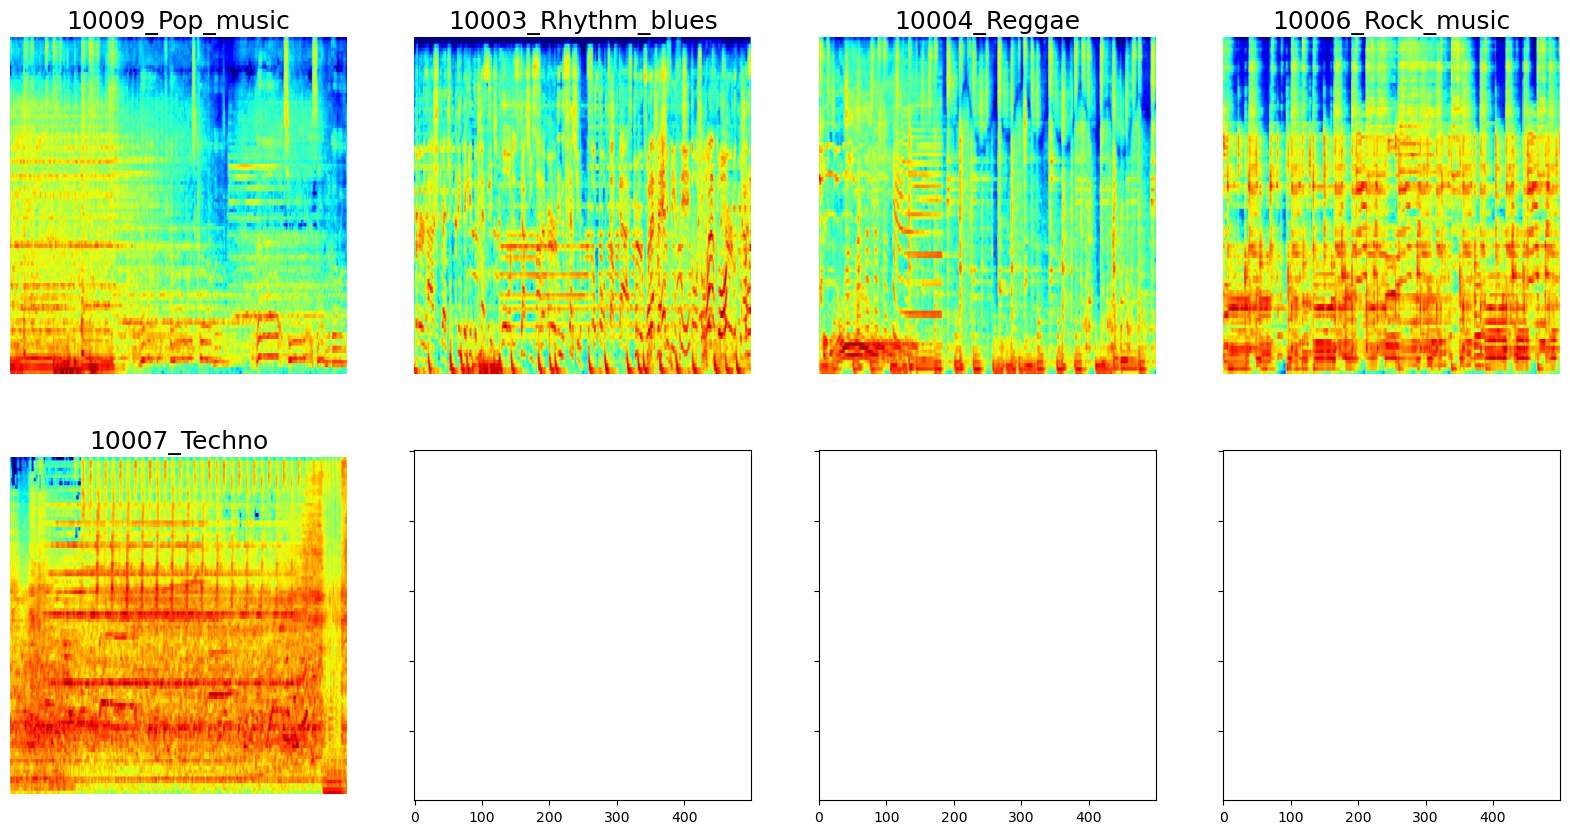

In [26]:
# Randomly select 1 spectrogram from each category for plotting
sample_files = ['136_Hip_hop_music.jpg', 
                 '10009_Pop_music.jpg',
                 '44153_Vocal.jpg',
                 '10003_Rhythm_blues.jpg',
                 '10004_Reggae.jpg',
                 '10006_Rock_music.jpg',
                 '10007_Techno.jpg']

sample_files = ['10009_Pop_music.jpg',
                 '10003_Rhythm_blues.jpg',
                 '10004_Reggae.jpg',
                 '10006_Rock_music.jpg',
                 '10007_Techno.jpg']

f, axarr = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20,10))
coordinates = [(0,0),(0,1),(0,2),(0,3), 
               (1,0),(1,1),(1,2) ]

for i, file_ in enumerate(sample_files):
    im = Image.open(specto_dir + file_)
    # im = im.resize((IMG_WIDTH, IMG_HEIGHT), resample = Image.ANTIALIAS)
    axarr[coordinates[i]].imshow(np.asarray(im))
    axarr[coordinates[i]].axis('off')
    axarr[coordinates[i]].set_title(file_[:-4], fontsize=18)

#### Define pretrained ResNet model from Pytorch

In [4]:
conv_base = models.resnet152(weights='DEFAULT')
in_features = conv_base.fc.in_features
conv_base.fc = torch.nn.Identity()

In [5]:
class L2RegularizedLinear(nn.Module):
  def __init__(self, in_features, out_features, l2_lambda):
    super(L2RegularizedLinear, self).__init__()
    self.linear = nn.Linear(in_features, out_features)
    self.l2_lambda = l2_lambda
  
  def forward(self, x):
    output = self.linear(x)
    l2_reg = torch.norm(self.linear.weight) * self.l2_lambda
    output += l2_reg
    return output


model = nn.Sequential(
  conv_base,
  nn.Flatten(),
  L2RegularizedLinear(in_features, 512, L2_LAMBDA),
  nn.Dropout(p=0.3),
  nn.ReLU(),
  nn.Linear(512, NUM_CLASSES),
  nn.Softmax(dim=-1)
)

In [6]:
# fine tuning, allow resnet pretrained weights to be trainable
for param in conv_base.parameters():
    param.requires_grad = True

In [ ]:
summary(model)

#### Training Resnet

In [ ]:
# should have transfer learning, but for now skipped since no 
# models are saved

In [7]:
# # load images, prepare labels, and normalize 
# def load_batch(file_list):
#     img_array = []
#     idx_array = []
#     label_array = []

#     for file_ in file_list:
#         im = Image.open(specto_dir + file_)
#         im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.Resampling.LANCZOS)
#         img_array.append(np.array(im))

#         vals = file_[:-4].split('_')
#         idx_array.append(vals[0])
#         label_array.append([label_dict[vals[1]]])

#     label_array = one_hot.fit_transform(label_array).toarray()
#     img_array = np.array(img_array)/255.0 # Normalize RGB
    
#     return img_array, np.array(label_array), np.array(idx_array)

In [8]:
# def batch_generator(files, BATCH_SIZE):
#     L = len(files)

#     batch_start = 0
#     batch_end = BATCH_SIZE

#     while batch_start < L:
        
#         limit = min(batch_end, L)
#         file_list = files[batch_start: limit]
#         batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)

#         # Convert numpy arrays to PyTorch tensors
#         batch_img_array = torch.tensor(batch_img_array, dtype=torch.float32)
#         batch_label_array = torch.tensor(batch_label_array, dtype=torch.float32)
        

#         yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

#         batch_start += BATCH_SIZE   
#         batch_end += BATCH_SIZE

In [9]:
# set training optimizer, loss, and metrics
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_function = torch.nn.functional.cross_entropy

def categorical_accuracy(output, target):
    predicted = torch.argmax(output, dim=0)
    correct = (predicted == target).float()
    return correct.sum() 

In [52]:
print(device)

cuda:0


In [38]:
# Calculate number of steps per epoch
STEPS_PER_EPOCH = len(train_files) // BATCH_SIZE
VAL_STEPS = len(val_files) // BATCH_SIZE

# Initialize lists to store training and validation losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

model.to(device)

# Training loop
for epoch in range(NUM_EPOCHS):
    # Training
    model.train()  # Set the model to train mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader), total=STEPS_PER_EPOCH):
        # Permute the inputs to [N, C, H, W] from [N, H, W, C]
        inputs = inputs.permute(0, 3, 1, 2)
        inputs = inputs.to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_function(outputs, targets)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        train_loss += loss.item()
        # aggregate total number correct
        correct_train += categorical_accuracy(outputs, targets)
        total_train += targets.size(0)
        # _, predicted = outputs.max(1)
        # correct_train += predicted.eq(targets).sum().item()

    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / STEPS_PER_EPOCH
    train_accuracy = 100. * correct_train / total_train

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(val_loader), total=VAL_STEPS):
            # Permute the inputs to [N, C, H, W] from [N, H, W, C]
            inputs = inputs.permute(0, 3, 1, 2)
            inputs = inputs.to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.float32)
            outputs = model(inputs)  # Forward pass
            loss = loss_function(outputs, targets)  # Calculate the loss
            val_loss += loss.item()
            # _, predicted = outputs.max(1)
            total_val += targets.size(0)
            correct_val += categorical_accuracy(outputs, targets)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / VAL_STEPS
    val_accuracy = 100. * correct_val / total_val

    # Print training and validation metrics
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, '
          f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Save the model checkpoint
    cur_dir = os.getcwd()
    root_dir = os.path.dirname(cur_dir)
    ckpt_dir = os.path.join(root_dir, f'saved_models/fine_tuning_epoch_{epoch + 1}_{val_accuracy:.4f}.pt')
    torch.save(model.state_dict(), ckpt_dir)

    # Append metrics to lists for plotting later if needed
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/3962 [00:00<?, ?it/s]

 56%|█████▌    | 2202/3962 [26:15<20:59,  1.40it/s]


KeyboardInterrupt: 

In [ ]:
# Save scores on train and validation sets

cur_dir = os.getcwd()
root_dir = os.path.dirname(cur_dir)
pkl_dir = os.path.join(root_dir, 'pickle_files/fine_tuning_resnet152_pytorch_history.pkl')

history = {
    'train_loss': train_losses,
    'train_accuracy': train_accuracies,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies,
}

with open(pkl_dir, 'wb') as f:
    pickle.dump(history, f)

In [ ]:
cur_dir = os.getcwd()
root_dir = os.path.dirname(cur_dir)
pkl_dir = os.path.join(root_dir, 'pickle_files/fine_tuning_resnet152_pytorch_history.pkl')

with open(pkl_dir, 'rb') as f:
    scores = pickle.load(f)
    
print(scores.keys())
scores = pd.DataFrame(scores, index=range(1,11))

In [ ]:
plt.xticks(range(1,11))
plt.plot(scores['train_loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()
plt.savefig('plots/learning-curve-loss.png')

In [ ]:
plt.xticks(range(1,11))
plt.plot(scores['train_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()
plt.savefig('plots/learning-curve-accuracy.png')

##### Need to find best model epoch

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred), 
                      classes=label_dict.keys())

In [ ]:
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels[:len(pred)], y_pred=pred)))
print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true=test_labels[:len(pred)], y_pred=pred, average='macro')))

In [ ]:
one_hot_true = one_hot_encoder(test_labels, len(pred), len(label_dict))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))

In [ ]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])    

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (Area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()